# Evaluation of orbiter orbit decay due to drag

In [22]:
import json
import numpy as np
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from numba import njit

%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [23]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [24]:
# import sys
# sys.path.append("../")
# import pyxplorer as pxp

## Drag analysis

In [25]:
MU_TITAN = 8.978138845307376E+03
R_TITAN = 2575.0  # km

In [26]:
1345.5e20 * 6.67408e-11 / 1e9  # check

8979.97464

In [27]:
# beta = m/(cd * area)

In [28]:
# mass = 1500.0  # kg
# area = np.pi * 2**2
# cd = 2.5
# beta = mass / (cd*area)
# beta   # kg/m^2

mass = 945.0  # kg
area = 2*2
cd = 2.5
beta = (mass/(cd*area)) # kg/m^2
beta   # kg/m^2

94.5

In [29]:
rho0 = 5.4  # kg/m^3
h0 = 50.0   # km, between 50km and 15km

def density_exponential(sma):
    """SMAD equation (9-31)"""
    h  = sma - R_TITAN  # km
    delta_h = h - h0    # km
    rho = rho0 * np.exp(-delta_h/h0)
    return rho  # kg/m^3

In [30]:
def decay_sma_circular_per_revolution(sma_km, fun_rho, beta):
    """SMAD equation (9-34)"""
    # compute rho
    rho = fun_rho(sma_km)
    # change in SMA
    sma_si = sma_km * 1e3  # meters
    delta_sma = -2*np.pi*(1/beta)*rho*sma_si**2  # meters
    return delta_sma/1e3   # km

In [31]:
# test function
sma0 = pxp.R_TITAN + 900
decay_sma_circular_per_revolution(sma0, density_exponential, beta)

-0.0

In [32]:
def sma_decay_history(sma0, t_horizon, mu, beta, fun_rho):
    # initialize running values and storage
    t_running = 0.0
    sma_current = sma0
    times, sma_history, periods = [t_running,], [sma0,], []
    while t_running <= t_horizon:
        #print(f"t_running = {t_running:1.4e}, t_horizon = {t_horizon:1.4e}")
        # get current period
        period = 2*np.pi*np.sqrt(sma_current**3/mu)
        # get sma decay
        delta_sma = decay_sma_circular_per_revolution(sma_current, fun_rho, beta)
        sma_new = sma_current + delta_sma
        if sma_new <= R_TITAN:
            break
        # update time
        t_running += period
        # store
        times.append(t_running)
        sma_history.append(sma_new)
        periods.append(period)
        # update
        sma_current = sma_new
    return np.array(times), np.array(sma_history), np.array(periods)

In [33]:
# analysis function over time-horizon
t_horizon = 5*365*86400.0 # seconds
t_horizon

157680000.0

In [34]:
times, sma_history, _ = sma_decay_history(sma0, t_horizon, MU_TITAN, beta, fun_rho=density_exponential)
sma_history

array([2575900., 2575900.])

In [35]:
sma0_list = R_TITAN + np.linspace(1000,1500,30)
sma0_list

array([3575.        , 3592.24137931, 3609.48275862, 3626.72413793,
       3643.96551724, 3661.20689655, 3678.44827586, 3695.68965517,
       3712.93103448, 3730.17241379, 3747.4137931 , 3764.65517241,
       3781.89655172, 3799.13793103, 3816.37931034, 3833.62068966,
       3850.86206897, 3868.10344828, 3885.34482759, 3902.5862069 ,
       3919.82758621, 3937.06896552, 3954.31034483, 3971.55172414,
       3988.79310345, 4006.03448276, 4023.27586207, 4040.51724138,
       4057.75862069, 4075.        ])

In [36]:
dat_sma0s = []
for sma0_try in sma0_list:
    dat_sma0s.append(
        (sma_decay_history(sma0_try, t_horizon, MU_TITAN, beta, fun_rho=density_exponential))
    )

In [37]:
dat_sma0s[0]

(array([    0.        , 14174.27253448, 28195.91774431, 41967.18849443,
        55173.61641042]),
 array([3575.        , 3549.29019659, 3506.91202671, 3410.35118828,
        2780.45891857]),
 array([14174.27253448, 14021.64520982, 13771.27075012, 13206.42791599]))

<IPython.core.display.Javascript object>


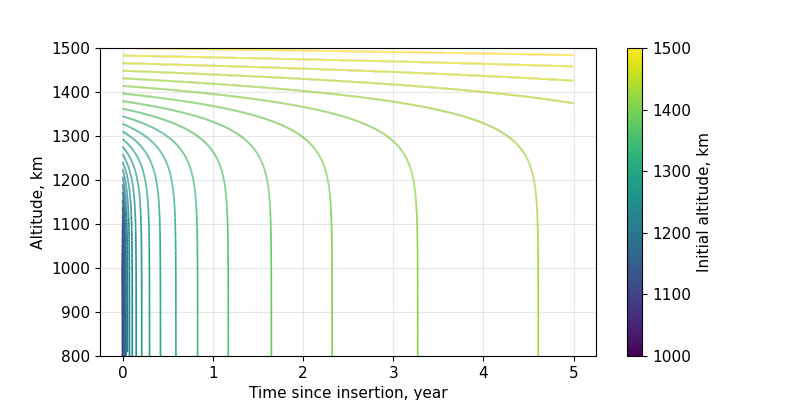

In [38]:
plt.rcParams["font.size"] = 11

fig, ax = plt.subplots(1,1,figsize=(8,4))

for idx,dat in enumerate(dat_sma0s):
    ax.plot(dat[0]/86400/365.25, dat[1]-R_TITAN, lw=0.0)  # PLACEHOLDER HACK FOR SIZING FIGURE!!
    # create line collection object for each trajectory
    lc = pxp.get_lc_traj_singleColor(
        xs=dat[0]/86400/365.25, ys=dat[1]-R_TITAN, 
        c=dat[1][0]-R_TITAN, vmin=min(sma0_list)-R_TITAN, vmax=max(sma0_list)-R_TITAN, cmap='viridis', lw=1.2
    )
    line = ax.add_collection(lc)

# display colorbar
fig.colorbar(line, ax=ax, label="Initial altitude, km")
ax.grid(True, alpha=0.3)
ax.set_ylim([800, 1500])

ax.set(xlabel="Time since insertion, year", ylabel="Altitude, km")
plt.show()

In [39]:
fig.savefig("./plots/titan_orbiter_decay.png")

### Evaluate hohmann cost to counter the change at each orbit

In [40]:
def raise_sma(mu, sma0, dsma):
    """Modify SMA from `sma0` to `sma0+dsma`"""
    # circular velocities
    smaf = sma0 + dsma
    v0 = np.sqrt(mu/sma0)
    vf = np.sqrt(mu/smaf)
    # compute Hohmann ellipse velocities
    smaH = (sma0 + smaf)/2
    vH0 = np.sqrt(mu*(2/sma0 - 1/smaH))
    vHf = np.sqrt(mu*(2/smaf - 1/smaH))
    # compute Delta-V cost
    dv_total = np.abs(vH0 - v0) + np.abs(vf - vHf)
    return dv_total

In [41]:
def sma_correct_history(sma0, t_horizon, mu, beta, fun_rho):
    # initialize running values and storage
    t_running = 0.0
    dv_running = 0.0
    sma_current = sma0
    times, sma_history, dv_history, dv_cummulative = [t_running,], [sma0,], [0.0,], [0.0,]
    while t_running <= t_horizon:
        # get current period
        period = 2*np.pi*np.sqrt(sma_current**3/mu)
        # get sma decay if no correction is applied over one period
        delta_sma = np.abs(decay_sma_circular_per_revolution(sma_current, fun_rho, beta))
        
        # compute cost to raise SMA after half of the orbit
        dv_raise = raise_sma(mu, sma_current-delta_sma/2, delta_sma/2)
        dv_running += dv_raise
        
        # update SMA
        sma_new = sma_current
        t_running += period
        
        # store
        times.append(t_running)
        sma_history.append(sma_new)
        dv_history.append(dv_raise)
        dv_cummulative.append(dv_running)
        
        # update
        sma_current = sma_new
    return np.array(times), np.array(sma_history), np.array(dv_cummulative)

In [42]:
dat_sma0s_raise = []
for sma0_try in sma0_list:
    dat_sma0s_raise.append(
        (sma_correct_history(sma0_try, t_horizon, MU_TITAN, beta, fun_rho=density_exponential))
    )

<IPython.core.display.Javascript object>


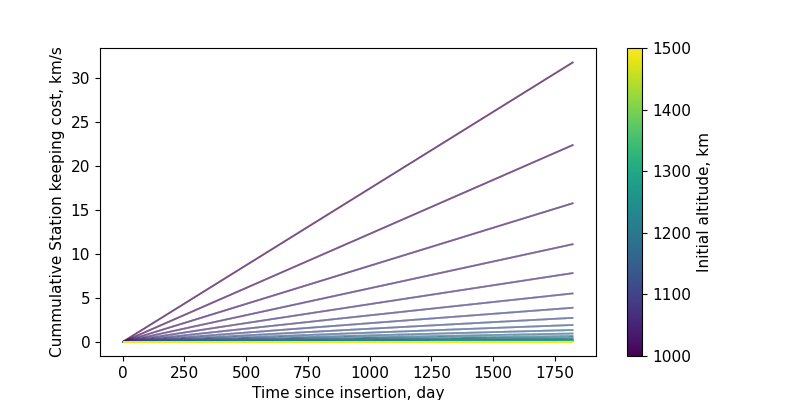

In [43]:
plt.rcParams["font.size"] = 11

fig, ax = plt.subplots(1,1,figsize=(8,4))

for idx,dat in enumerate(dat_sma0s_raise):
    ax.plot(dat[0]/86400, dat[2], lw=0.0)  # PLACEHOLDER HACK FOR SIZING FIGURE!!
    # create line collection object for each trajectory
    lc = pxp.get_lc_traj_singleColor(
        xs=dat[0]/86400, ys=dat[2], 
        c=dat[1][0]-R_TITAN, vmin=min(sma0_list)-R_TITAN, vmax=max(sma0_list)-R_TITAN, cmap='viridis', lw=1.2
    )
    line = ax.add_collection(lc)

# display colorbar
fig.colorbar(line, ax=ax, label="Initial altitude, km")
    
ax.set(xlabel="Time since insertion, day", ylabel="Cummulative Station keeping cost, km/s")
plt.show()